# Importing dependencies

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Data Loading

## Download and normalize to range [-1, 1]

In [0]:
dataset_train = torchvision.datasets.MNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [0]:
dataset_test = torchvision.datasets.MNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [0]:
# Change labels of dataset to real
dataset_train.targets = torch.ones(len(dataset_train))
dataset_test.targets = torch.ones(len(dataset_test))

In [0]:
labels_map = {0: 'Fake', 1: 'Real'}

## Concatenating train and test dataset

In [6]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [7]:
torch.cuda.is_available()

True

In [0]:
epochs = 20
output_after_every_n = 1
image_size = 28
input_size = 100
batch_size = 64
num_channels = 1

In [0]:
# Function to help us plot batches (it is used with torchvision.utils.make_grid)
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Convert into DataLoader

In [0]:
datasetloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [0]:
# This is just for visualization and a little debugging
dataiter = iter(datasetloader)

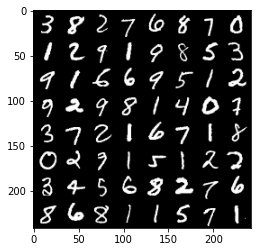

In [12]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [0]:
def initialize_weights(m): 
	if type(m) == nn.Linear:
		torch.nn.init.xavier_uniform_(m.weight)
		m.bias.data.fill_(0.01)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [0]:
class Generator(nn.Module):
  '''
  The Generator Network
  '''

  def __init__(self):
    super(Generator, self).__init__()

    self.linear_1 = nn.Sequential(
        nn.Linear(input_size, 256),
        nn.LeakyReLU(0.2)
    )
    # Out 256

    self.linear_2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    # Out 512

    self.linear_3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
    )
    # Out 1024

    self.output_layer = nn.Sequential(
        nn.Linear(1024, image_size ** 2),
        nn.Tanh()
    )
    # Out 784


    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
  
  def forward(self, inputs):
    x = self.linear_1(inputs)
    x = self.linear_2(x)
    x = self.linear_3(x)
    generated_image = self.output_layer(x)
    return generated_image.view(generated_image.size(0), num_channels, image_size, image_size)

In [15]:
generator = Generator()
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (linear_1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


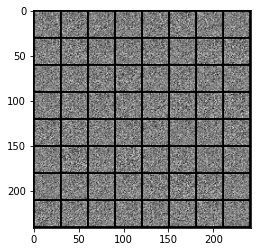

Generator(
  (linear_1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [16]:
with torch.no_grad():
  generator.eval()
  _, labels = dataiter.next()
  noise = torch.randn(size=(batch_size, input_size)).cuda()
  output = generator(noise).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [0]:
class Discriminator(nn.Module):
  '''
  The Discriminator Network
  '''
  def __init__(self):
    super(Discriminator, self).__init__()

    self.linear_1 = nn.Sequential(
        nn.Linear(image_size ** 2, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    # Out 1024
    
    self.linear_2 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    # Out 512

    self.linear_3 = nn.Sequential(
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    # Out 256

    self.output_layer = nn.Sequential(
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
    # Out 1

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
  
  def forward(self, inputs):
    x = inputs.view(inputs.size(0), image_size ** 2)
    x = self.linear_1(x)
    x = self.linear_2(x)
    x = self.linear_3(x)
    return self.output_layer(x) 

In [18]:
discriminator = Discriminator()
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (linear_1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Specifying Loss function

In [0]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [0]:
def plot_output():
  plt.clf()
  with torch.no_grad():
    input_noise = torch.randn(size=(batch_size, input_size)).cuda()
    
    generator.eval()
    test_images = generator(input_noise)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
  show_grid(grid)
  return grid

# Training GAN

Epoch: 1 / 20
Discriminator Total Loss: 0.681, Generator Total Loss: 1.774


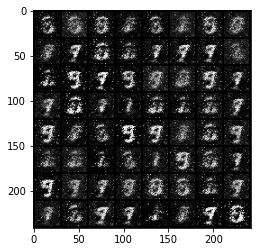

Epoch: 2 / 20
Discriminator Total Loss: 0.658, Generator Total Loss: 2.066


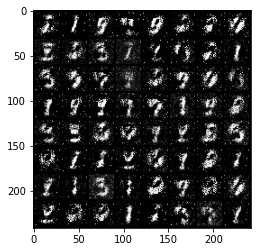

Epoch: 3 / 20
Discriminator Total Loss: 0.649, Generator Total Loss: 2.127


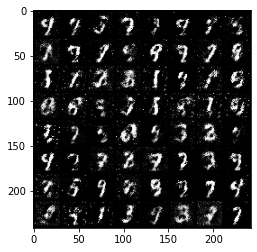

Epoch: 4 / 20
Discriminator Total Loss: 0.777, Generator Total Loss: 1.815


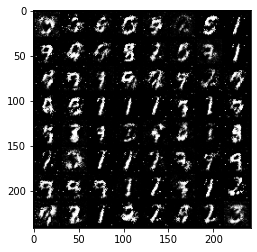

Epoch: 5 / 20
Discriminator Total Loss: 0.914, Generator Total Loss: 1.495


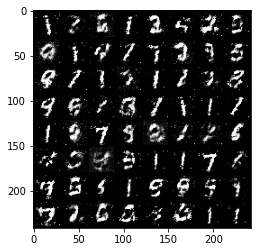

Epoch: 6 / 20
Discriminator Total Loss: 1.037, Generator Total Loss: 1.241


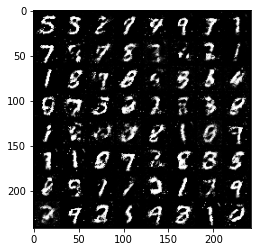

Epoch: 7 / 20
Discriminator Total Loss: 1.095, Generator Total Loss: 1.132


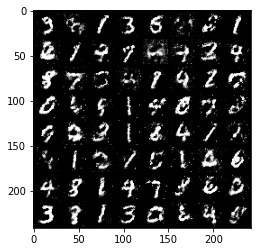

Epoch: 8 / 20
Discriminator Total Loss: 1.149, Generator Total Loss: 1.052


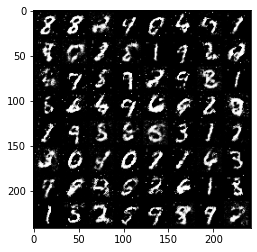

Epoch: 9 / 20
Discriminator Total Loss: 1.185, Generator Total Loss: 0.989


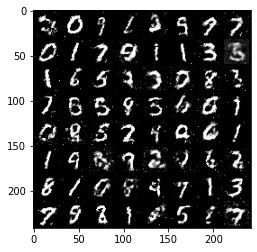

Epoch: 10 / 20
Discriminator Total Loss: 1.207, Generator Total Loss: 0.960


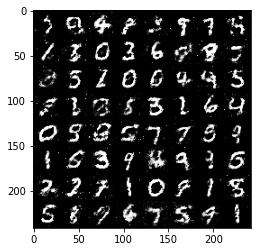

Epoch: 11 / 20
Discriminator Total Loss: 1.224, Generator Total Loss: 0.939


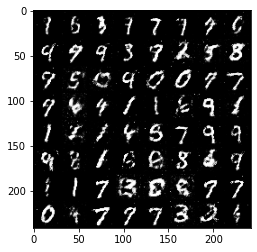

Epoch: 12 / 20
Discriminator Total Loss: 1.243, Generator Total Loss: 0.910


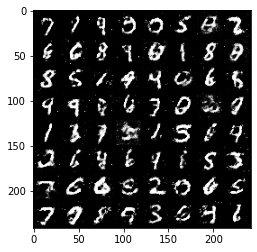

Epoch: 13 / 20
Discriminator Total Loss: 1.252, Generator Total Loss: 0.893


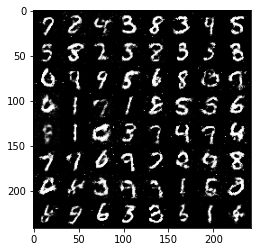

Epoch: 14 / 20
Discriminator Total Loss: 1.255, Generator Total Loss: 0.887


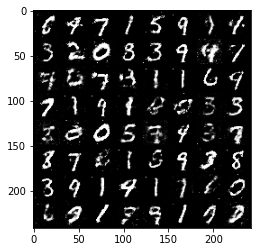

Epoch: 15 / 20
Discriminator Total Loss: 1.262, Generator Total Loss: 0.881


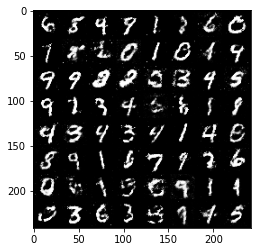

Epoch: 16 / 20
Discriminator Total Loss: 1.267, Generator Total Loss: 0.875


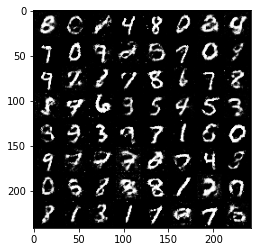

Epoch: 17 / 20
Discriminator Total Loss: 1.264, Generator Total Loss: 0.875


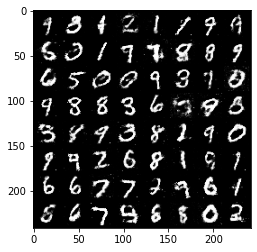

Epoch: 18 / 20
Discriminator Total Loss: 1.270, Generator Total Loss: 0.865


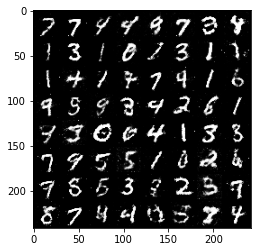

Epoch: 19 / 20
Discriminator Total Loss: 1.269, Generator Total Loss: 0.867


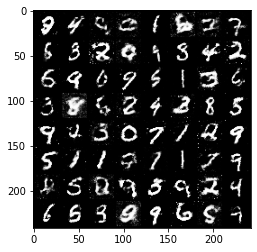

Epoch: 20 / 20
Discriminator Total Loss: 1.273, Generator Total Loss: 0.863


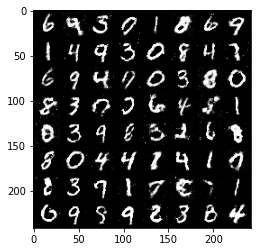

In [21]:
# Set tdqm for epoch progress
pbar = tqdm()
images = []

for epoch in range(epochs):
  print(f'Epoch: {epoch + 1} / {epochs}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []

  for real_images, real_labels in datasetloader:

    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.type('torch.FloatTensor').cuda() # Already converted to ones earlier
    fake_labels = torch.zeros(current_batch_size, dtype=torch.float).cuda()

    # Training Generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, input_size)).cuda()
    fake_images = generator(input_noise)

    ## Calculate Generator loss
    discriminator_fake_labels = discriminator(fake_images)
    
    generator_total_loss = adversarial_loss(discriminator_fake_labels.squeeze(), real_labels)
    generator_total_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_total_loss)

    # Training Discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_labels = discriminator(real_images)
    discriminator_real_loss = adversarial_loss(discriminator_real_labels.squeeze(), real_labels)

    ## Loss for fake images
    discriminator_fake_labels = discriminator(fake_images.detach())
    discriminator_fake_loss = adversarial_loss(discriminator_fake_labels.squeeze(), fake_labels)

    ## Total loss
    discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
    discriminator_total_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_total_loss)

    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))


  if (epoch + 1) % output_after_every_n == 0:
    grid = plot_output()
    images.append(transforms.ToPILImage()(grid))

pbar.refresh()
# Save gif of output
images[0].save('digitmnist-gan.gif', save_all=True, append_images=images[1:])